In [26]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


In [27]:
from PIL import Image
import glob
import os

print("PIL 라이브러리 import 완료!")

PIL 라이브러리 import 완료!


## 데이터 불러 오기

### 데이터 로드 함수 정의



In [57]:
import os
from PIL import Image

AUTOTUNE = tf.data.experimental.AUTOTUNE
image_size = 224
BATCH_SIZE = 16

# 하나의 디렉토리(dir_path)의 이미지화일(.jpg, .jpeg)을 읽어서 list를 리턴하는 함수
# 이 때 이미지를 (target_size, target_size)로 리사이즈 한다.
def load_images_from_dir(dir_path, target_size = 224):
    """
    Loads all '.jpg' and '.jpeg' files from a directory, including its subdirectories.
    This function is case-insensitive for file extensions.

    :param root_directory: The root directory to start the search from.
    :return: A list of PIL Image objects.
    """
    images = []
    for root, dirs, files in os.walk(dir_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg')):
                file_path = os.path.join(root, file)
                try:
                    img = Image.open(file_path)
                    new_img = img.resize((target_size, target_size),Image.ANTIALIAS)
                    images.append(new_img)
                except IOError:
                    print(f"Cannot load image: {file_path}")
    return images

### 이미지 화일을 읽어서 폴더별로 라벨링 한다.
- 라벨은 헤당 클래스가 class_dir_list에 나타나는 순서

In [58]:
# import numpy as np
import os

class_dir_list = ["barrel_jellyfish",          # 0
                    "blue_jellyfish",          # 1
                   "compass_jellyfish",        # 2
                   "lions_mane_jellyfish",     # 3
                    "mauve_stinger_jellyfish", # 4
                    "Moon_jellyfish"]          # 5

# 하위 디렉토리(class_dir_list에 있는)를 순회하면서 이미지 화일을 읽고
# 디렉토리에 따라 라벨링을 해준다.
# 라벨은 class_dir_list에 나타나는 해파리명의 순서
def load_data_with_label(img_path, max_number_of_data=10000, class_dir_list = ""):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=224
    color=3

    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    images=np.zeros(max_number_of_data*img_size*img_size*color,dtype=np.int32).reshape(max_number_of_data,img_size,img_size,color)
    labels=np.zeros(max_number_of_data,dtype=np.int32)

    idx=0
    
    for label, dir_name in enumerate(class_dir_list):
        class_image_dir = img_path + "/" + dir_name
        class_images = load_images_from_dir(class_image_dir)
        for i in range(len(class_images)):
            images[idx, :, :, :] = class_images[i]
            labels[idx] = label
            idx += 1
    
    print("데이터의 이미지 개수는", idx,"입니다.")
    images = images[:idx]
    labels = labels[:idx]

    return images, labels


### train, validataion, test data와 label을 로드한다.

In [59]:
file_root = "/aiffel/aiffel/jellyfish/Train_Test_Valid/"

train_data, train_labels = load_data_with_label(file_root + "Train",
                           class_dir_list = class_dir_list)

val_data, val_labels = load_data_with_label(file_root + "valid",
                           class_dir_list = class_dir_list)

test_data, test_labels = load_data_with_label(file_root + "test",
                           class_dir_list = class_dir_list)


데이터의 이미지 개수는 896 입니다.
데이터의 이미지 개수는 39 입니다.
데이터의 이미지 개수는 39 입니다.


In [60]:
type(train_data)

numpy.ndarray

In [ ]:
import tensorflow as tf

def rotate_image(image):
    return tf.image.rot90(image)

def zoom_image(image):
    # 이미지 중심을 기준으로 확대
    return tf.image.central_crop(image, 0.5)

def adjust_contrast_image(image):
    return tf.image.adjust_contrast(image, 2)

def adjust_brightness_image(image):
    return tf.image.adjust_brightness(image, 0.1)


def flip_left_right_image(image):
    return tf.image.flip_left_right(image)

def augment_dataset_with_labels(data, labels):
    augmented_data = []
    augmented_labels = []

    for image, label in zip(data, labels):
        augmented_images = [
            image,
            flip_left_right_image(image).numpy(),
            zoom_image(image).numpy(),
            adjust_contrast_image(image).numpy(),
            adjust_brightness_image(image).numpy()
        ]

        for aug_image in augmented_images:
            augmented_data.append(aug_image)
            augmented_labels.append(label)

    return np.vstack(augmented_data), np.vstack(augmented_labels)

# 데이터셋 적용 예시
# train_data, train_label = ...

train_data, train_labels = augment_dataset_with_labels(train_data, train_labels)

In [ ]:
train_data.shape()

In [48]:
train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_data, val_labels))

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

In [38]:
augmented_train_data.shape

(4480,)

In [ ]:
import tensorflow as tf

# Assuming t_dataset is already created as shown in your example
# t_dataset = ...

# Counting the number of elements in the dataset
num_elements = sum(1 for _ in t_dataset)

print(f"Number of elements in t_dataset: {num_elements}")


In [ ]:
def prepare_dataset(dataset, shuffle_buffer_size=1200, batch_size=16):
    dataset = dataset.shuffle(buffer_size=shuffle_buffer_size)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    return dataset

In [24]:
t_prepared_dataset = prepare_dataset(t_dataset)
v_prepared_dataset = prepare_dataset(v_dataset)

In [ ]:
original_dataset_size = len(t_prepared_dataset)  # Assuming train_data has one entry per sample
batch_size = 16  # As defined in your prepare_dataset function

# Number of batches per epoch
num_batches = -(-original_dataset_size // batch_size)  # Ceiling division

print(f"Number of batches per epoch in t_prepared_dataset: {num_batches}")



### 로드한 이미지 그려 보기

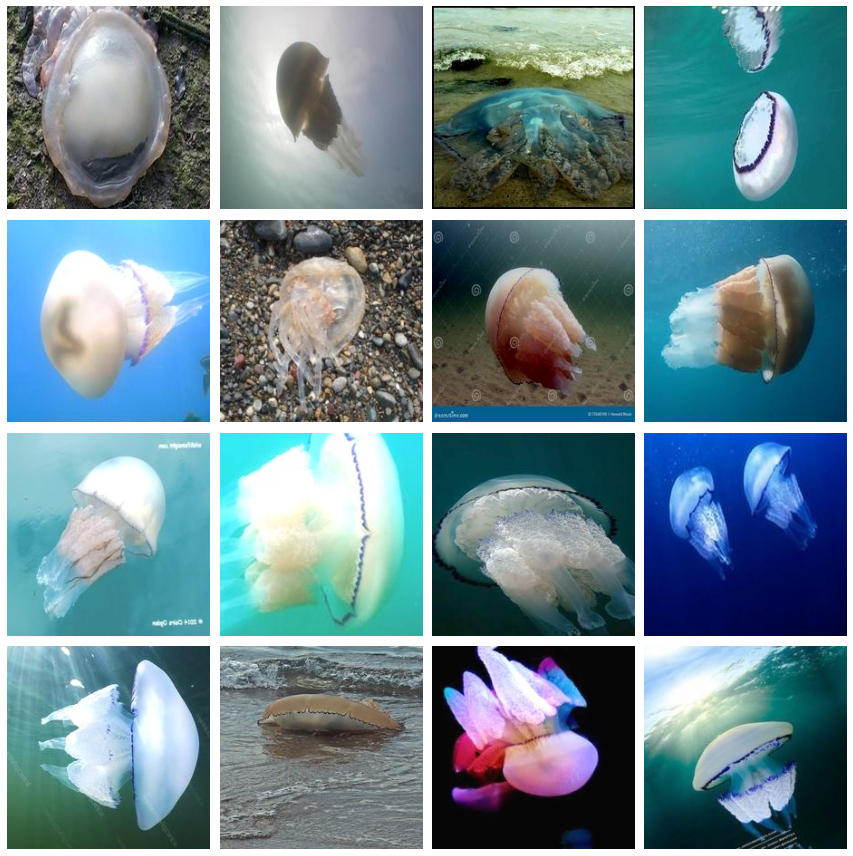

In [11]:
import matplotlib.pyplot as plt

def show_images_in_matrix(images, rows=4, cols=4):
    """
    Displays images in a grid format using matplotlib.

    :param images: A list of PIL Image objects.
    :param rows: The number of rows in the image grid.
    :param cols: The number of columns in the image grid.
    """
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    axes = axes.ravel()

    for i in range(rows * cols):
        if i < len(images):
            axes[i].imshow(images[i])
            axes[i].axis('off')
        else:
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()
    
show_images_in_matrix(train_data[:16])
    
# Example usage:
# images = [Your list of PIL Image objects]
# show_images_in_matrix(images)

# Replace [Your list of PIL Image objects] with a list of PIL Image objects.


### 데이터 shape 확인

In [11]:
print(train_data.shape)
print(train_label.shape)

print(val_data.shape)
print(val_label.shape)

print(test_data.shape)
print(test_label.shape)


(896, 224, 224, 3)
(896,)
(39, 224, 224, 3)
(39,)
(39, 224, 224, 3)
(39,)


In [12]:
# 데이터셋 확인
for batch in prepared_dataset.take(1):
    images_batch, labels_batch = batch
    print("Batch shape:", images_batch.shape)
    print("Label shape:", labels_batch.shape)

Batch shape: (32, 224, 224, 3)
Label shape: (32,)


### 데이터 scale 조정

In [ ]:
train_data = train_data / 255.0   # 입력은 0~1 사이의 값으로 정규화
val_data = val_data / 255.0   # 입력은 0~1 사이의 값으로 정규화
test_data = test_data / 255.0   # 입력은 0~1 사이의 값으로 정규화

print("train_data shape: {}".format(train_data.shape))
print("train_label shape: {}".format(train_label.shape))

### 스케일 조정된 데이터 확인

In [9]:
train_data[0]

array([[[0.34509804, 0.38039216, 0.2745098 ],
        [0.13333333, 0.16862745, 0.0627451 ],
        [0.27058824, 0.30588235, 0.2       ],
        ...,
        [0.24705882, 0.2627451 , 0.17254902],
        [0.14117647, 0.15686275, 0.06666667],
        [0.28235294, 0.29803922, 0.2       ]],

       [[0.3372549 , 0.36862745, 0.2745098 ],
        [0.12156863, 0.15294118, 0.05882353],
        [0.13333333, 0.16862745, 0.0627451 ],
        ...,
        [0.16470588, 0.18039216, 0.09019608],
        [0.25882353, 0.2745098 , 0.18431373],
        [0.27843137, 0.29411765, 0.19607843]],

       [[0.19607843, 0.22745098, 0.13333333],
        [0.23529412, 0.26666667, 0.17254902],
        [0.28627451, 0.31764706, 0.22352941],
        ...,
        [0.31764706, 0.33333333, 0.24313725],
        [0.32156863, 0.3372549 , 0.24705882],
        [0.35686275, 0.37254902, 0.2745098 ]],

       ...,

       [[0.00392157, 0.05098039, 0.04313725],
        [0.04313725, 0.09019608, 0.08235294],
        [0.01960784, 0

### 모델 정의
- LeNet의 정의을 그대로 따랐다.
- 가장 큰 차이는 convolution layer를 하나 더 넣었다는 것이다.

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers

import numpy as np

# model을 직접 만들어 보세요.
# Hint! model의 입력/출력부에 특히 유의해 주세요. 가위바위보 데이터셋은 MNIST 데이터셋과 어떤 점이 달라졌나요?
n_channel_1=32
n_channel_2=32
n_channel_3=64
n_dense_1= 128
n_dense_2 = 64
n_train_epoch=50

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), \
                              activation='relu', \
                              input_shape=(image_size,image_size,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Conv2D(n_channel_3, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
#model.add(keras.layers.Conv2D(n_channel_3, (3,3), activation='relu'))
#model.add(keras.layers.MaxPooling2D((2,2)))

model.add(keras.layers.Flatten())
#model.add(keras.layers.Dense(n_dense_1, activation='relu'))
#model.add(keras.layers.BatchNormalization())  # Batch Normalization
model.add(keras.layers.Dense(n_dense_2, activation='relu'))
#model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(6, activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 43264)             0

### 학습 실행

In [19]:

model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])


# 훈련 및 평가
history = model.fit(t_prepared_dataset, 
                    epochs=n_train_epoch,
                    steps_per_epoch=900 // BATCH_SIZE,
                    batch_size = 16,
                    validation_steps=40 // BATCH_SIZE,
                    validation_data=(v_prepared_dataset))

Epoch 1/50
56/56 [==============================] - 7s 69ms/step - loss: 1.7918 - accuracy: 0.1674 - val_loss: 1.7913 - val_accuracy: 0.2500
Epoch 2/50
56/56 [==============================] - 4s 67ms/step - loss: 1.7917 - accuracy: 0.1585 - val_loss: 1.7915 - val_accuracy: 0.1250
Epoch 3/50
56/56 [==============================] - 4s 67ms/step - loss: 1.7918 - accuracy: 0.1685 - val_loss: 1.7909 - val_accuracy: 0.3125
Epoch 4/50
56/56 [==============================] - 4s 66ms/step - loss: 1.7918 - accuracy: 0.1685 - val_loss: 1.7918 - val_accuracy: 0.1875
Epoch 5/50
56/56 [==============================] - 4s 65ms/step - loss: 1.7918 - accuracy: 0.1719 - val_loss: 1.7916 - val_accuracy: 0.1250
Epoch 6/50
56/56 [==============================] - 4s 66ms/step - loss: 1.7918 - accuracy: 0.1618 - val_loss: 1.7922 - val_accuracy: 0.1250
Epoch 7/50
56/56 [==============================] - 4s 65ms/step - loss: 1.7918 - accuracy: 0.1596 - val_loss: 1.7923 - val_accuracy: 0.0625
Epoch 8/50
56

KeyboardInterrupt: 

### 학습 결과(accuracy, loss) 그래프

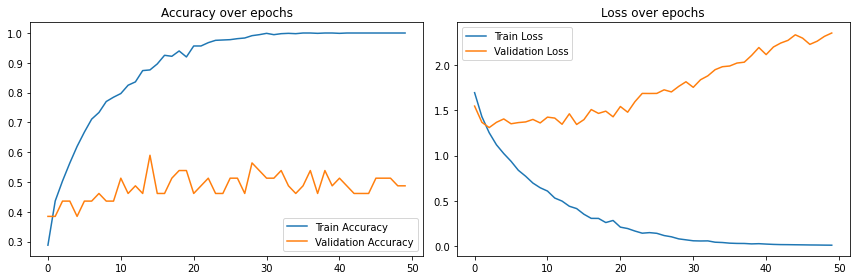

In [83]:
# 4. 결과를 그래프로 표시
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over epochs')

plt.tight_layout()
plt.show()

### 테스트 정확도 

In [84]:
# model을 학습시키는 코드를 직접 작성해 보세요.
# Hint! model.evaluate()을 사용해 봅시다.
test_loss, test_accuracy = model.evaluate(test_data, test_label, verbose=2)
print(f"test_loss: {test_loss} ")
print(f"test_accuracy: {test_accuracy}")

2/2 - 0s - loss: 2.3409 - accuracy: 0.5385
test_loss: 2.3409383296966553 
test_accuracy: 0.5384615659713745


### 테스트 추론 결과와 라벨 비교

model.predict() 결과 :  [9.79589000e-02 7.13695347e-01 7.62593467e-03 1.06981825e-04
 1.80042192e-01 5.70673379e-04]
model이 추론한 가장 가능성이 높은 결과 :  1
실제 데이터의 라벨 :  1


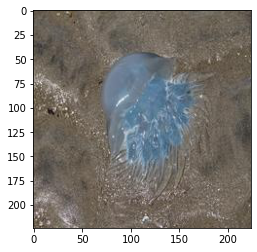

model.predict() 결과 :  [7.6833049e-07 2.0045852e-07 1.3313888e-04 3.6804939e-03 9.9618536e-01
 3.1959668e-09]
model이 추론한 가장 가능성이 높은 결과 :  4
실제 데이터의 라벨 :  4


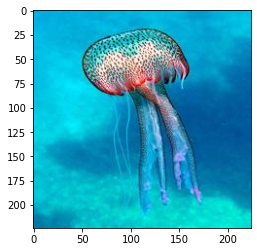

model.predict() 결과 :  [2.6391991e-09 9.6527231e-01 3.6640605e-04 1.6718744e-06 3.4358196e-02
 1.3958806e-06]
model이 추론한 가장 가능성이 높은 결과 :  1
실제 데이터의 라벨 :  1


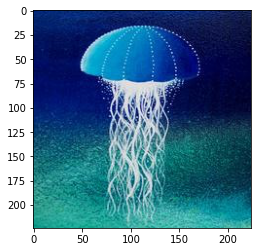

model.predict() 결과 :  [2.6700977e-06 8.0289249e-04 1.4030420e-09 2.2226422e-10 1.4467038e-06
 9.9919301e-01]
model이 추론한 가장 가능성이 높은 결과 :  5
실제 데이터의 라벨 :  5


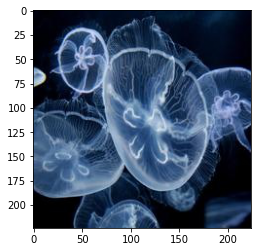

model.predict() 결과 :  [1.7847501e-06 4.3738996e-06 2.7951848e-04 9.8770010e-01 1.2013312e-02
 9.8098883e-07]
model이 추론한 가장 가능성이 높은 결과 :  3
실제 데이터의 라벨 :  3


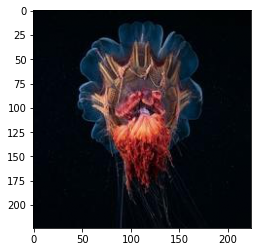

model.predict() 결과 :  [2.0791340e-05 3.9169298e-15 3.3072728e-01 6.6925192e-01 9.9713604e-10
 3.0532090e-15]
model이 추론한 가장 가능성이 높은 결과 :  3
실제 데이터의 라벨 :  3


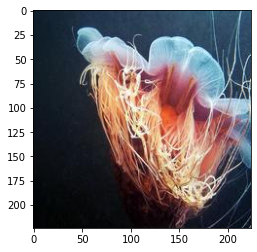

model.predict() 결과 :  [5.7975452e-02 2.1310941e-08 1.9167179e-01 7.4619210e-01 4.1606058e-03
 1.0261128e-08]
model이 추론한 가장 가능성이 높은 결과 :  3
실제 데이터의 라벨 :  2


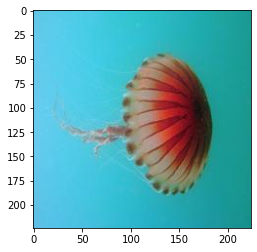

model.predict() 결과 :  [1.5579818e-01 6.1778868e-05 1.4725764e-02 4.6791084e-02 1.4776585e-02
 7.6784664e-01]
model이 추론한 가장 가능성이 높은 결과 :  5
실제 데이터의 라벨 :  0


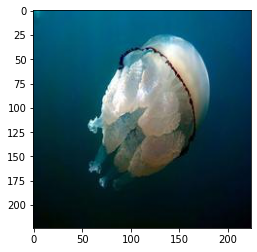

model.predict() 결과 :  [1.9282625e-07 2.9655849e-04 5.1880193e-09 1.9676051e-11 6.4849910e-06
 9.9969685e-01]
model이 추론한 가장 가능성이 높은 결과 :  5
실제 데이터의 라벨 :  5


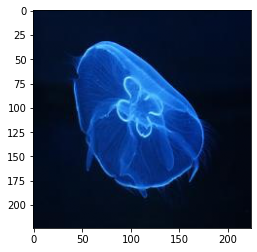

model.predict() 결과 :  [9.8613966e-01 2.4867214e-03 5.9949184e-06 5.4436714e-06 1.1139378e-02
 2.2288263e-04]
model이 추론한 가장 가능성이 높은 결과 :  0
실제 데이터의 라벨 :  4


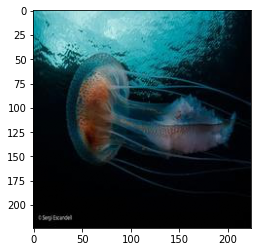

In [85]:
predicted_result = model.predict(test_data)  # model이 추론한 확률값. 
#print(predicted_result)
predicted_labels = np.argmax(predicted_result, axis=1)

for idx in np.random.choice(len(predicted_labels), 10):
    #idx=150 #1번째 x_test를 살펴보자. 
    print('model.predict() 결과 : ', predicted_result[idx])
    print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
    print('실제 데이터의 라벨 : ', test_label[idx])

    plt.imshow(test_data[idx])
    plt.show()